In [28]:
#%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
import math
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [2]:
def normalization(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

# Choosing data

In [59]:
df = pd.read_csv("new_dtrain.csv", delimiter=",")
zeros = df[df['latitude'] == 0]
df = df[df['latitude'] != 0]
subset = list(df.columns.values)
subset = subset.remove('price')
data = df.drop_duplicates(subset = subset)
#print(len(data[data.price > 1000000000]))
data = data[data.price < 1000000000]
data = data[data.price < 800000000]
data = data[data.price < 400000000]

data.replace(-1, 0, inplace=True)
data.replace(' С ', '0', inplace=True)

data = shuffle(data)
data = data.reset_index(drop=True)

In [60]:
# data = log_feature(data)
#choosing data
X = data[['room_number', 'house_type', 'district',
       'built_time', 'appartments_floor', 'all_space', 'state', 'bathroom',
       'balcony', 'balcony_glassed', 'door', 'phone', 'ceiling', 'safety',
       'at_the_hotel', 'internet', 'furniture', 'parking', 'building_floors', 'map_complex', 'floor',
          'trngl_first_point', 'trngl_second_point', 'trngl_third_point']]
# X_geo = data[['geocode_lat', 'geocode_long', 'trngl_first_point', 'trngl_second_point', 'trngl_third_point']]
#'latitude','longitude'
y = data['price']
# x_columns = X.columns
# x_index = X.index
# X = normalization(X)
# X = pd.DataFrame(X, index=x_index, columns=x_columns)
# X = pd.concat([X, X_geo], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

# Models 

In [61]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
# model = KNeighborsRegressor(n_neighbors = 5, n_jobs=-1, p=1)
# model.fit(X_train, y_train)

In [62]:
gbr_model = GradientBoostingRegressor(n_estimators = 100, learning_rate=0.1, 
                                  random_state=7, max_depth=10)
rfr_model = RandomForestRegressor(n_estimators = 300, random_state=7)
# logreg_model = LogisticRegression(C=0.5, n_jobs=-1)

In [63]:
gbr_model.fit(X_train, y_train)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

# Metrics

In [64]:
# print(model.score(X_test, y_test))
print(gbr_model.score(X_test, y_test))
print(rfr_model.score(X_test, y_test))

0.890271296247
0.895948388344


In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RFR Mean absolute error: ", mean_absolute_error(rfr_model.predict(X_test), y_test))
print("GBR Mean absolute error: ", mean_absolute_error(gbr_model.predict(X_test), y_test))
# print("KNN Regressor absolute error: ", mean_absolute_error(model.predict(X_test), y_test))

RFR Mean absolute error:  3130271.38422
GBR Mean absolute error:  3208211.289


# Overfitting

In [21]:
print("RFR Mean absolute error: ", mean_absolute_error(rfr_model.predict(X_train), y_train))
print("GBR Mean absolute error: ", mean_absolute_error(gbr_model.predict(X_train), y_train))
# print("KNN Regressor absolute error: ", mean_absolute_error(model.predict(X_train), y_train))

RFR Mean absolute error:  1150351.81681
GBR Mean absolute error:  969590.060006


# Stacking

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression
linear_model = LinearRegression()

In [23]:
def stack_out(data):
    stack = pd.DataFrame()
#     stack['knn'] = model.predict(data)
    stack['rfr'] = rfr_model.predict(data)
    stack['gbr'] = gbr_model.predict(data)
    return stack

In [24]:
linear_model.fit(stack_out(X_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
print("Stacking output(MAE): ", mean_absolute_error(linear_model.predict(stack_out(X_test)), y_test))

Stacking output(MAE):  3303421.55139


# Printing 

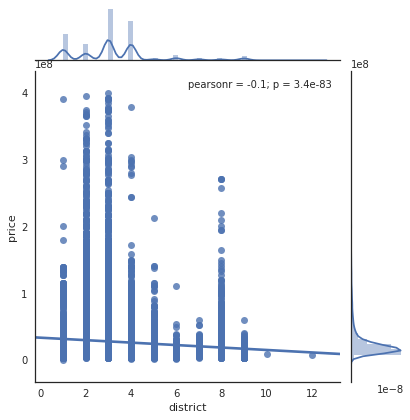

In [29]:
g = sns.jointplot(x = data['district'], y = data['price'], kind="reg")

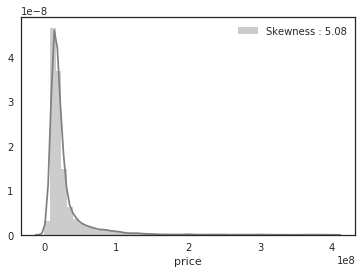

In [34]:
g = sns.distplot(data['price'],color="grey")
g = g.legend(['Skewness : {:.2f}'.format(data['price'].skew())],loc='best')

In [36]:
def RMSE(estimator,X_train, y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

# Boosting Machines

In [38]:
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [45]:
X_train['room_number'] = pd.to_numeric(X_train['room_number'])
X_test['room_number'] = pd.to_numeric(X_test['room_number'])

In [46]:
LightGB.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', colsample_bytree=1, feature_fraction=0.2319,
       feature_fraction_seed=9, learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_data_in_leaf=6, min_split_gain=0, min_sum_hessian_in_leaf=11,
       n_estimators=720, nthread=-1, num_leaves=5, objective='regression',
       reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
       subsample_for_bin=50000, subsample_freq=1)

In [47]:
print("LightGBM MAE: ", mean_absolute_error(LightGB.predict(X_test), y_test))

LightGBM MAE:  16974760.3939


In [48]:
XGBoost = xgb.XGBRegressor()

In [49]:
XGBoost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [50]:
print("LightGBM MAE: ", mean_absolute_error(XGBoost.predict(X_test), y_test))

LightGBM MAE:  4978629.25348
